# Analiza društvene mreže Reddit

Univerzitet u Beogradu, Elektrotehnički fakultet, veb adresa [ovde](https://www.etf.bg.ac.rs).  
Predmet: Analiza socijalnih mreža, veb adresa [ovde](https://rti.etf.bg.ac.rs/rti/ms1asm/).  
Tekst projektnog zadatka se može naći na veb sajtu predmeta [ovde](https://rti.etf.bg.ac.rs/rti/ms1asm/projekti/2021-2022/ASM_PZ2_2122.pdf).  
- Bogdan Bebić 2022/3051
- Marta Avramović 2022/3166

## Instalacija i učitavanje korišćenih biblioteka
Neophodne bilioteke se mogu instalirati korišćenjem Python package instalera `pip`.

In [1]:
import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

## Format skupa podataka
Podaci su preuzeti sa sajta predmeta i otpakovani u odgovarajuće direktorijume.
Kako postoji više datoteka sa istim tipom podataka, učitavamo ih sve zajedno i spajamo u jedinstvenu strukturu podataka.

In [2]:
reddit_data_path = "ASM_PZ2_podaci_2122/reddit2008"
submission_dataPath = f"{reddit_data_path}/submissions_2008_asm/"
comments_dataPath = f"{reddit_data_path}/comments_2008_asm_v1.1/comments_2008/"


def loadDataSet(folderPath):
    allFileData = pd.DataFrame([])
    for fileName in os.listdir(folderPath):
        singleFileData = pd.read_csv(folderPath + fileName, low_memory=False)
        allFileData = pd.concat([allFileData, singleFileData])

    return allFileData


def groupby_count(data_frame, groupby_list):
    return data_frame.groupby(groupby_list).size().reset_index(name="counts")


def groupby_count_sorted(data_frame, groupby_list):
    return groupby_count(data_frame, groupby_list).sort_values('counts', ascending=False)

## Filtriranje skupa podataka
Na društvenoj mreži Reddit je moguće obrisati nalog - u tom slučaju se mogu dobiti podaci koji sadrže `[deleted]` kao korisničko ime.
Ovakvi podaci nepovoljno utiču na analizu jer su ti nalozi mogli pripadati proizvoljnom broju korisnika i stoga ih filtriramo i ne koristimo u daljoj analizi.

In [3]:
submissionData = loadDataSet(submission_dataPath)
commentsData = loadDataSet(comments_dataPath)

# It is possible to have "[deleted]" as author name
submissionFilter = submissionData["author"] != "[deleted]"
commentsFilter = commentsData["author"] != "[deleted]"

filteredSubmissions = submissionData[submissionFilter]
filteredComments = commentsData[commentsFilter]

allData = pd.concat([filteredSubmissions, filteredComments])

## Statistička obrada podataka

In [4]:
allSubredditIds = np.union1d(submissionData['subreddit_id'], commentsData['subreddit_id'])
print(f"Number of different subreddits: {len(allSubredditIds)}")

commentsPerSubreddit = groupby_count_sorted(commentsData, ["subreddit_id"])
print(f"Comments per subreddit:\n{commentsPerSubreddit[:1]}")

# subreddit - author - count interactions
interactionsPerAuthorPerSubreddit = groupby_count(allData, ["subreddit_id", "author"])
# subreddit - count authors
authorsPerSubreddit = groupby_count_sorted(interactionsPerAuthorPerSubreddit, ["subreddit_id"])
print(f"Authors per subreddit:\n{authorsPerSubreddit[:1]}")

print(f"AVG number users per subreddit:\n{authorsPerSubreddit['counts'].sum() / len(allSubredditIds)}")

submissionsPerAuthor = groupby_count_sorted(filteredSubmissions, ['author'])
commentsPerAuthor = groupby_count_sorted(filteredComments, ['author'])
print(f"Max submissions per author:\n{submissionsPerAuthor[:1]}")
print(f"Max comments per author:\n{commentsPerAuthor[:1]}")

# author - subreddit - count interactions
interactionsPerSubredditPerAuthor = groupby_count(allData, ['author', 'subreddit_id'])
# author - count subreddits
subredditsPerAuthor = groupby_count_sorted(interactionsPerSubredditPerAuthor, ['author'])
print(f"Subreddits per author:\n{subredditsPerAuthor[:1]}")

Number of different subreddits: 5032
Comments per subreddit:
     subreddit_id   counts
2689         t5_6  1884629
Authors per subreddit:
     subreddit_id  counts
4354         t5_6  163779
AVG number users per subreddit:
128.78398251192368
Max submissions per author:
      author  counts
84823    gst   18870
Max comments per author:
                author  counts
12603  NoMoreNicksLeft   13480
Subreddits per author:
         author  counts
26173  MrKlaatu     181


Pearson correlation matrix:
                    counts_submissions  counts_comments
counts_submissions            1.000000         0.150412
counts_comments               0.150412         1.000000


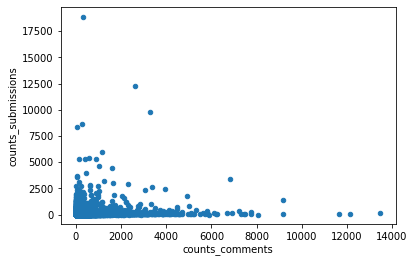

In [5]:
paersonCalculation = submissionsPerAuthor.copy().merge(commentsPerAuthor.copy(), on="author", how="inner", suffixes=["_submissions", "_comments"])
paersonCalculation.plot.scatter(y="counts_submissions", x="counts_comments")
print(f"Pearson correlation matrix:\n{paersonCalculation.corr(method='pearson')}")

In [6]:
filterNonOver18 = submissionData["over_18"] == False
filteredSubmissionsNonOver18 = submissionData[filterNonOver18]
extractedCommentsData = pd.DataFrame(commentsData["link_id"].map(lambda element: element.split("_")[1]))
commentsDataSubmissionId = groupby_count_sorted(extractedCommentsData, ["link_id"]).rename(columns={"link_id": "id"})
filteredSubmissionsNonOver18JoinedComments = filteredSubmissionsNonOver18.merge(commentsDataSubmissionId, how="inner", on="id")
topSubmissionsNonOver18JoinedComments = filteredSubmissionsNonOver18JoinedComments.sort_values(by="counts", ascending=False)[:10]
print(topSubmissionsNonOver18JoinedComments)
topSubmissionsNonOver18JoinedComments.to_csv("top_submission_non_over_18.csv")

        Unnamed: 0     id                                                url  \
290534      191390  7kpe5  https://www.reddit.com/r/AskReddit/comments/7k...   
574617      111467  6nz1k                          http://hundredpushups.com   
57505       135995  675oj  https://www.reddit.com/r/reddit.com/comments/6...   
942221      191265  78n1v  http://www.time.com/time/nation/article/0,8599...   
133696       36220  7beo2  https://www.reddit.com/r/politics/comments/7be...   
488720       73206  6jbc0  https://www.reddit.com/r/reddit.com/comments/6...   
764729      197408  6yn6t                   http://www.cnbc.com/id/26454655?   
721214       84267  6w7e6  https://www.reddit.com/r/reddit.com/comments/6...   
136018       41921  7bj3f  http://www.latimes.com/news/local/la-me-gaymar...   
772368        4466  6z2e2  http://www.nytimes.com/reuters/us/internationa...   

                                                permalink        author  \
290534  /r/AskReddit/comments/7kpe5/i_am_con

## Modelovanje podataka grafovima
Skup podataka modelujemo pomoću 4 različita grafa:
1. SNet (Subreddit network) - sadrži kompletne podatke, sve sabredite i interakcije sa njima
2. SNetF (Subreddit network filtered) - filtrirani SNet na osnovu broja korisnika koji definišu interakciju izmedju više sabredita
3. SNetT (Subreddit network targeted) - filtrirani SNet na osnovu odabranih sabredita i grana kojima su povezani
4. UserNet - sadrži interakcije između korisnika - komentare na objave ili na komentare

Iz SNet eliminišemo sve čvorove koji nemaju nijednu granu kako bismo omogućili dalju analizu povezanosti čvorova grafa.

In [7]:
snet = nx.Graph()
snet.add_nodes_from(allSubredditIds)

authorSubredditIdGroups = allData.groupby(["author", "subreddit_id"]).groups
groups = dict()
for author, subredditId in authorSubredditIdGroups:
    if author not in groups:
        groups[author] = [subredditId]
    else:
        groups[author].append(subredditId)

for key in groups:
    subreddit_ids = groups[key]
    for i in range(0, len(subreddit_ids)):
        for j in range(i + 1, len(subreddit_ids)):
            if snet.has_edge(subreddit_ids[i], subreddit_ids[j]):
                snet.edges[subreddit_ids[i], subreddit_ids[j]]['weight'] += 1
            else:
                snet.add_edge(subreddit_ids[i], subreddit_ids[j], weight=1)

snet.remove_nodes_from(list(nx.isolates(snet)))

### Odabir praga za filtriranje grana po težini
Prag za filtriranje je uzet kao prosečna vrednost svih težina grana u grafu SNet.

In [8]:
average_weight = sum([tags["weight"] for u, v, tags in snet.edges(data=True)]) / len(snet.edges)
w_threshold = average_weight

# TODO: check if commented out works
# snetf = snet.edge_subgraph([(u, v) for u, v, tags in snet.edges(data=True) if tags["weight"] > w_threshold])

snetf = nx.Graph()
snetf.add_nodes_from(allSubredditIds)
snetf.add_edges_from([(u, v, tags) for u, v, tags in snet.edges(data=True) if tags["weight"] > w_threshold])

snetf.remove_nodes_from(list(nx.isolates(snetf)))

### Odabir sabredita od interesa
Sabrediti od interesa za analizu pomoću SNetT su uzeti iz teksta projektog zadatka.

In [9]:
targetSubreddits = {
    "reddit.com",
    "pics",
    "worldnews",
    "programming",
    "business",
    "politics",
    "obama",
    "science",
    "technology",
    "WTF",
    "AskReddit",
    "netsec",
    "philosophy",
    "videos",
    "offbeat",
    "funny",
    "entertainment",
    "linux",
    "geek",
    "gaming",
    "comics",
    "gadgets",
    "nsfw",
    "news",
    "environment",
    "atheism",
    "canada",
    "math",
    "Economics",
    "scifi",
    "bestof",
    "cogsci",
    "joel",
    "Health",
    "guns",
    "photography",
    "software",
    "history",
    "ideas",
}

targetSubredditIds = [allData[allData["subreddit"] == targetSubreddit]["subreddit_id"].unique()[0] for targetSubreddit in targetSubreddits]
snett = snet.subgraph(targetSubredditIds)

### UserNet
Modelujemo interakcije korisnika društvene mreže usmerenim grafom.

In [10]:
authorComments = pd.concat([filteredComments["author"], filteredComments["link_id"].map(lambda element: element.split("_")[1])], axis=1).rename(columns={"link_id": "id"})
authorToAuthorInteractions = groupby_count(authorComments.merge(allData[["author", "id"]], on="id", how="inner", suffixes=["_from", "_to"]), ["author_from", "author_to"])
edge_list = authorToAuthorInteractions.rename(columns={"author_from": "source", "author_to": "target", "counts": "weight"})
usernet = nx.from_pandas_edgelist(edge_list, edge_attr=True, create_using=nx.DiGraph)

Dobijene grafove čuvamo u standardnom `gml` formatu na disku kako bismo im mogli pristupati i iz eksternih alata.

In [101]:
# nx.write_gml(snet, "snet.gml")
# nx.write_gml(snetf, "snetf.gml")
# nx.write_gml(snett, "snett.gml")
# nx.write_gml(usernet, "usernet.gml")

### Generisanje Erdos-Renyi mreža
Erdos-Renyi mreže koristimo za poređenje sa mrežama reddit podataka.

Verovatnoća za stvaranje grana u grafu je odabrana kao gustina grafova koje ispitujemo.

In [102]:
# erdos_renyi_snet = nx.erdos_renyi_graph(n=snet.number_of_nodes(), p=nx.density(snet))
# erdos_renyi_snetf = nx.erdos_renyi_graph(n=snetf.number_of_nodes(), p=nx.density(snetf))
# erdos_renyi_usernet = nx.erdos_renyi_graph(n=usernet.number_of_nodes(), p=nx.density(usernet), directed=True)

In [103]:
# nx.write_gml(erdos_renyi_snet, "erdos_renyi_snet.gml")
# nx.write_gml(erdos_renyi_snetf, "erdos_renyi_snetf.gml")
# nx.write_gml(erdos_renyi_usernet, "erdos_renyi_usernet.gml")

## Analiza modelovanih grafova
### Klub bogatih
Kako bi izvrsavanje funkcija trajalo kratko, koristi se nenormalizovana varijanta.
Kao sto se moze videti sa grafika dole, grafovi ispoljavaju klub bogatih (cvorovi su u klubu bogatih za vrednosti 1).

<AxesSubplot:title={'center':'SNetF rich club coefficient'}>

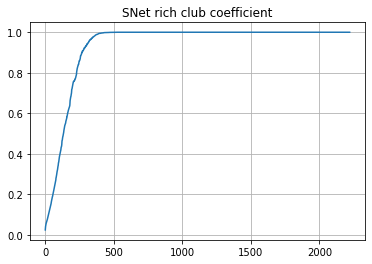

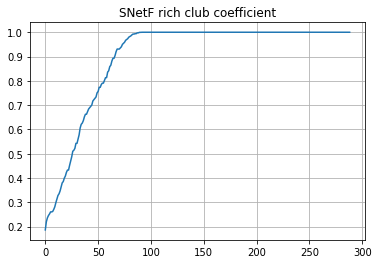

In [11]:
snet_rich_club_coefficient = nx.rich_club_coefficient(snet, normalized=False)
snetf_rich_club_coefficient = nx.rich_club_coefficient(snetf, normalized=False)

pd.DataFrame.from_dict(snet_rich_club_coefficient, orient="index").plot(title="SNet rich club coefficient", grid=True, legend=False)
pd.DataFrame.from_dict(snetf_rich_club_coefficient, orient="index").plot(title="SNetF rich club coefficient", grid=True, legend=False)

### Asortativna analiza
Kako su vrednosti koeficijenata asortativnosti manje od 0, ove mreže su disortitativna - čvorovi ne teže da se povežu sa sličnim čvorovima.

Degree assortativity (SNet) -0.436456805812687
Degree assortativity (SNetF) -0.6177660601425986


<AxesSubplot:title={'center':'SNetF'}, xlabel='average_neighbor_degree', ylabel='degree'>

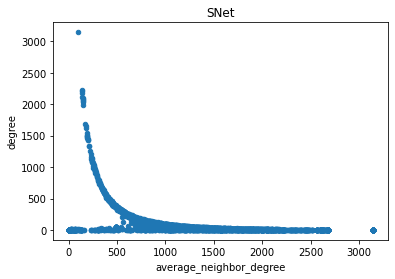

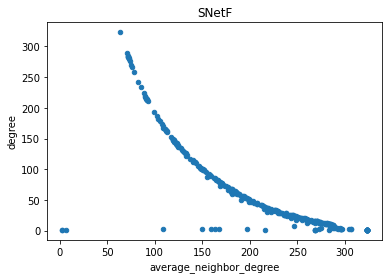

In [34]:
print(f"Degree assortativity (SNet) {nx.degree_assortativity_coefficient(snet)}")
print(f"Degree assortativity (SNetF) {nx.degree_assortativity_coefficient(snetf)}")

snet_node_degrees = {key: value for key, value in snet.degree}
snet_average_neighbor_degree = nx.average_neighbor_degree(snet)

snet_degree_average_neighbor_degree = pd.DataFrame.from_records([snet_node_degrees, snet_average_neighbor_degree]).T.rename(columns={ 0: "degree", 1: "average_neighbor_degree"})
snet_degree_average_neighbor_degree.plot.scatter(x="average_neighbor_degree", y="degree", title="SNet")

snetf_node_degrees = {key: value for key, value in snetf.degree}
snetf_average_neighbor_degree = nx.average_neighbor_degree(snetf)

snetf_degree_average_neighbor_degree = pd.DataFrame.from_records([snetf_node_degrees, snetf_average_neighbor_degree]).T.rename(columns={ 0: "degree", 1: "average_neighbor_degree"})
snetf_degree_average_neighbor_degree.plot.scatter(x="average_neighbor_degree", y="degree", title="SNetF")

### Stepen čvora i power law
Mreže ne prate power law raspodelu.

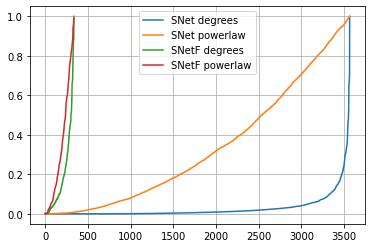

In [12]:
snet_sorted_degrees = np.array(sorted([degree for node_id, degree in snet.degree]))
snet_sorted_degrees_normalized = snet_sorted_degrees / snet_sorted_degrees[-1]
snet_x_axis = np.linspace(0, len(snet_sorted_degrees), len(snet_sorted_degrees))
snet_sorted_power_law = sorted(np.random.power(0.5, len(snet_sorted_degrees)))
plt.plot(snet_x_axis, snet_sorted_degrees_normalized, label="SNet degrees")
plt.plot(snet_x_axis, snet_sorted_power_law, label="SNet powerlaw")

snetf_sorted_degrees = np.array(sorted([degree for node_id, degree in snetf.degree]))
snetf_sorted_degrees_normalized = snetf_sorted_degrees / snetf_sorted_degrees[-1]
snetf_x_axis = np.linspace(0, len(snetf_sorted_degrees), len(snetf_sorted_degrees))
snetf_sorted_power_law = sorted(np.random.power(0.5, len(snetf_sorted_degrees)))
plt.plot(snetf_x_axis, snetf_sorted_degrees_normalized, label="SNetF degrees")
plt.plot(snetf_x_axis, snetf_sorted_power_law, label="SNetF powerlaw")

plt.legend()
plt.grid()

### Katz centrality
Isti čvorovi su centralni i po ovoj metrici, nezavisno od menjanja parametra beta.
```
t5_6 = reddit.com
t5_2qh16 = technology
t5_2cneq = politics
```

In [13]:
def calculate_katz_centrality(G, beta_scalar):
    beta_dict = dict()
    for node_id in G.nodes:
        beta_dict[node_id] = 1.0 if node_id != "t5_6" else beta_scalar

    return nx.katz_centrality(G, alpha=0.0005, beta=beta_dict, max_iter=1000)

count_of_most_important = 3

print("SNet Katz central nodes:")
snet_katz_dict_1 = calculate_katz_centrality(snet, 1.0)
print(sorted(snet_katz_dict_1, key=lambda node_id: -snet_katz_dict_1[node_id])[:count_of_most_important])
snet_katz_dict_5 = calculate_katz_centrality(snet, 50.0)
print(sorted(snet_katz_dict_5, key=lambda node_id: -snet_katz_dict_5[node_id])[:count_of_most_important])
snet_katz_dict_10 = calculate_katz_centrality(snet, 100.0)
print(sorted(snet_katz_dict_10, key=lambda node_id: -snet_katz_dict_10[node_id])[:count_of_most_important])

print("SNetF Katz central nodes:")
snetf_katz_dict_1 = calculate_katz_centrality(snetf, 1.0)
print(sorted(snetf_katz_dict_1, key=lambda node_id: -snetf_katz_dict_1[node_id])[:count_of_most_important])
snetf_katz_dict_5 = calculate_katz_centrality(snetf, 50.0)
print(sorted(snetf_katz_dict_5, key=lambda node_id: -snetf_katz_dict_5[node_id])[:count_of_most_important])
snetf_katz_dict_10 = calculate_katz_centrality(snetf, 100.0)
print(sorted(snetf_katz_dict_10, key=lambda node_id: -snetf_katz_dict_10[node_id])[:count_of_most_important])

SNet Katz central nodes:
['t5_6', 't5_2qh16', 't5_2cneq']
['t5_6', 't5_2qh16', 't5_2cneq']
['t5_6', 't5_2qh16', 't5_2cneq']
SNetF Katz central nodes:
['t5_6', 't5_2cneq', 't5_2qh16']
['t5_6', 't5_2cneq', 't5_2qh16']
['t5_6', 't5_2cneq', 't5_2qh16']
